# 연구목표 : 목적

- 텐서플로우를 이용하여 예측 결과까지의 흐름을 확인 
- 절차적으로 어떤 것들이 나오는지 간략하게 확인
- 데이터는 BMK 지수 = 몸무게/키*키
- 비만도 측정한다 

# 데이터 획득

In [0]:
import numpy as np
import pandas as pd

In [0]:
df = pd.read_csv('/content/drive/My Drive/dl_data/3_bmi.csv')

In [0]:
df.head(2)

,height,weight,label
0,178,69,normal
1,190,62,thin


## label 값을 원-핫인코딩 응용으로 처리

- 딥러닝시 데이터는 모두 수치여야 하므로
- 레이블을 0과 1로 표현할 것인데 
- [1,0,0] or [0,1,0], or [0,0,1]으로 대체
- 레이블이 1칸으로 표현된다  
- 'thin' : [1,0,0] 
- 'normal' : [0,1,0]
- 'fat' : [0,0,1] <- ndarray 형으로 처리 

In [0]:
df.shape, df.columns, df.label.unique()

((20000, 3),
 Index(['height', 'weight', 'label'], dtype='object'),
 array(['normal', 'thin', 'fat'], dtype=object))

# 데이터 준비
- 품질 향상 !!

In [0]:
df2 = df[:]

mapping = {
'thin' : np.array([1,0,0]),
'normal' : np.array([0,1,0]),
'fat' : np.array([0,0,1])
} 

In [0]:
# df['label'] 값이 위에 언급된 배열로 세팅되게끔 처리 
df2['label'] = df2['label'].apply( lambda x : mapping[x] ) 
df2.head(2)

,height,weight,label
0,178,69,"[0, 1, 0]"
1,190,62,"[1, 0, 0]"


In [0]:
# 데이터를 훈련용, 테스트용 75:25로 분류 

In [0]:
# 'height'.'weight' = train 
# 'label' = test 

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( df2[ df2.columns[:2] ], df2['label'], random_state=0 )
X_train.shape, X_test.shape

((15000, 2), (5000, 2))

# 데이터 분석(생략)


# 데이터 모델링(딥러닝,텐서플로우)

## softmax 활성화함수 

- 입력받은 값을 출력으로 0~1 사이로 모두 정규화하여서 출력값들의 총합은 1이 되게하는 함수 
- softmax 함수의 출력값은 범주형 확률분포라고 표현하고
- 통상, 다중 클래스들을 예측할 때, 출력층에 도달하기 직전에 사용한다. output activation 으로 사용한다 

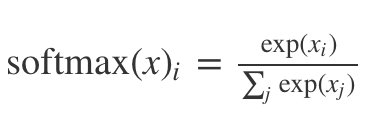

In [0]:
from IPython.display import Image

Image('/content/drive/My Drive/dl_data/sm0.png', width=300)

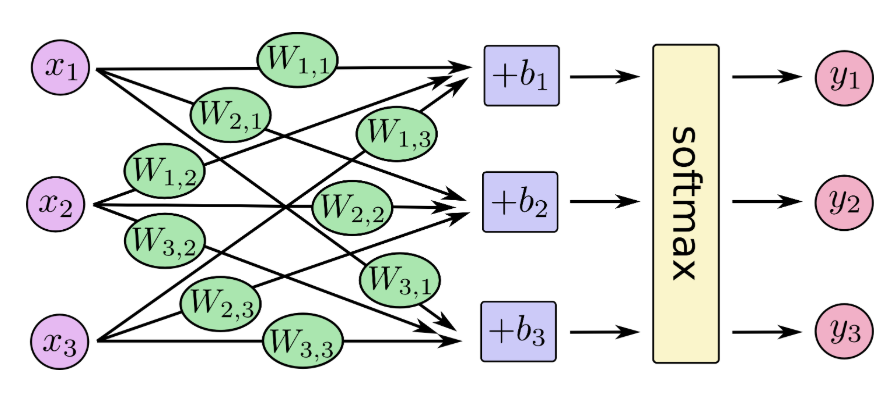

In [0]:
Image('/content/drive/My Drive/dl_data/sm1.png', width=300)

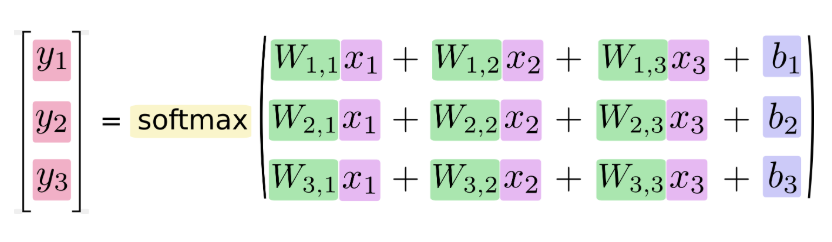

In [0]:
Image('/content/drive/My Drive/dl_data/sm2.png', width=300)
# y = softmax(Wx + b) 
# x가 (3,3) 이었다면, 
# y = softmax(Wx + b) <- 이렇게 표현 

- 1. X의 shape을 결정
- 2. W의 shape가 결정된다 (행렬의 곱은 교환법칙이 특수한 특수한 케이스 빼고는 성립이 안되므로)
- 3. b의 shape을 결정
- 4. y에 도달하기 위해서 활성화함수를 사용  
- 5. 필요하면 행렬을 플래툰하는 작업도 나올 수는 있다 y에 가기 위해서(여기서는 제외)

## 1분. 데이터 플로우 그래프 생성 

- y = softmax(xW + b)

In [0]:
import tensorflow as tf
%tensorflow_version 1.x

In [0]:
# x는 데이터가 주입이 된다 => 플레이스 홀더
# 데이터가 몇개 주입될지 모르겠으나, 각 데이터의 최종 성분은 2개이다  
x = tf.placeholder( tf.float32, [None, 2] )

In [0]:
# 가중치 => 값은 바뀔 수 있다 => 변수 
# W의 shape ( 2, 3 )
W = tf.Variable( tf.zeros( [2,3] ) )

In [0]:
# 편향, 바이어스 => 브로드 캐스팅에 의해서 자동 증가된다(shpae이)
# 차원을 자동으로 맞춰주어서 연산이 문제 없게 수행되도록 지원 
# b의 shape ( 3 ) => y에 맞춰서 계산 
b = tf.Variable( tf.zeros( [3] ) )

In [0]:
# y는 데이터 플로우 그래프, 계산식
# Y = SOFTMAX(x*W + b)
y = tf.nn.softmax( tf.matmul(x,W) + b )

In [0]:
'%s%s + %s = %s' % (x.shape, W.shape, b.shape, y.shape)

'(?, 2)(2, 3) + (3,) = (?, 3)'

## 2부. 실행 

- 최적화 기법이 가미 
  - 좋은 모델에 대한 정의 : 기준점 
    - 비용(cost), 손실(lose)등 값들이 원하는 값(임계치, 목표치)에서 얼마나 떨어져 있는가? 이것을 판단의 지표로 본다 
    - 줄이는 방향으로 간다 
    - 크로스 엔트로피와 같은 알고리즘을 적용한다 
    - 크로스 엔트로피 : 정보압축알고리즘, 배팅, 머신로닝 등등에서 주로 사용 

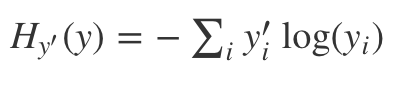

In [0]:
Image('/content/drive/My Drive/dl_data/sm4.png', width=300)

In [0]:
# y _ :  정답 레이블 => shape => [None, 3]
# y   :  예측 레이블 
y_ = tf.placeholder( tf.float32, [None, 3] )

In [0]:
# 클로스 엔트로피 데이터 플로우 그래프 
# reduce sum( 여기에 들어오는 행렬(tensor)들의 구성원들의 총합 )
cross_entropy = - tf.reduce_sum( y_*tf.log(y) )

In [0]:
# 크로스 엔트로피가 작동하여 최소화로 결과가 수렴되도록 작업이 진행 
# 이 진행을 담당하는 알고리즘이 경사 하강법 (Gradient Descent algorithm)
# 텐서플로우 엔진에서 변수를 비용이 줄어드는 방향으로 조금씩 이동시킨다 
# 이를 통해서 연산이 수행 => 비용, 손실값이 최소가 되도록 처리한다 
hyper_raram = 0.01
optimizer = tf.train.GradientDescentOptimizer(hyper_raram)

In [0]:
# 크로스 엔트로피와 경사하강법 연결
# minmize(), 손실값을 최소화하게끄 변수를 조금씩 이동시키는 함수
train = optimizer.minimize( cross_entropy )

In [0]:
# 예측 
# 결과, thin, normal, fat 에 대한 각각의 % 비율 중 가장 큰 값을 예측 값으로 판단 
# 이런 데이터 중에 최대값 => argmax  
predict = tf.equal( tf.argmax( y, 1 ), tf.argmax(y_, 1) )

In [0]:
# 정확도 
accuracy = tf.reduce_mean( tf.cast( predict, tf.float32 ) )

# 구성 

- 현재 데이터는 n개의 입력에 대해서, thin, normal, fat 등의 3개의 결론으로 도달하게 된다 
- 신경망 구성을 위해서는 퍼셉트론을 적용해본다면, n개의 입력(키, 몸무게, 15000, 5000)에 가중치를 곱하고, 편향(바이어스) 더한다(값을 올리거나, 내리거나) 이렇게 만들어진 값을 모두 합하여, 활성화함수(각각의 특성)를 통과시키면 결과에 도착하게 된다(출력층에 도달하게 된다)
- 이런 신경망을 여러개 구성할 수도 있지만, 여기서는 1개만 적용 
- 활성화 함수는 softmax()를 사용
- 입력대비 출력에 대한 식은 X*W + b 라는 퍼셉트론을 기반으로 구성하겠다  

## 실행 

- Session 획득
- 훈련데이터, 정답, 테스트 데이터 등을 주입하여 결과를 확인 

In [0]:
# 한번 훈련시킬 때 사용하는 데이터의 양
TRAIN_TERM = 100
with tf.Session() as sess : 
  # 1. tf의 모든 변수들을 초기화 
  sess.run( tf.global_variables_initializer() )
  # 2. 훈련 방법을 고려 => 15000 개를 한번에 넣을 것인가? 구간을 나눠서 사용할 것인가? 
  #    양이 중요한가? 혹은 횟수가 중요한가? : 횟수로 총 양을 맞출 수도 있다
  # 이런 데이터의 양을 가지고 몇번 훈련시킬 것인가 
  train_count = int(X_train.shape[0] / TRAIN_TERM)
  for step in range( train_count ) :
    # X_train 으로부터 이번 차수에 훈련할 데이터를 추출 
    # 훈련횟수를 늘린 이유는 경사하강법에 의해서 손실값이 이동됨을 확인하기 위함 
    offset = step*TRAIN_TERM
    # 3. 이번 차시에 훈련시킬 데이터를 획득 
    cur_train_data = X_train[ offset : offset + TRAIN_TERM : ]  
    # 4. 학습
    # 플로우에 주입할 데이터를 명시 => 플로우 상에 존재하는 모든 placeholder 를 기술  
    dic = {
        x : cur_train_data, # x에 들어가는 훈련용데이터 (100,2)
        y_ : list( y_train[ offset : offset + TRAIN_TERM ])                 
    }
    sess.run( train, feed_dict=dic )
    # 5. 중간평가 
    if step % 10 == 0 : 
      # 로그 출력 
      # 크로스 엔트로피값 획득 
      cross_en = sess.run( cross_entropy, feed_dict=dic )
      # 정확도 획득 => 훈련시 사용하지 않은 데이터 사용 
      # 중간 점검이므로, 학습에 영향을 미치지 않는다 
      # X_test, y_test 
      testDic = {
          x : X_test, 
          y_ : list( y_test )
      }
      acc = sess.run( accuracy, feed_dict=testDic )
      # 출력
      print( f'단계{step} 손실값={cross_en} 정확도={acc}')
# 훈련완료 
      testDic = {
          x : X_test, y_ : list( y_test )
          }
      acc = sess.run( accuracy, feed_dict=testDic )  
      print('정확도', acc)

단계0 손실값=143707.625 정확도=0.37880000472068787
정확도 0.3788
단계10 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계20 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계30 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계40 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계50 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계60 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계70 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계80 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계90 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계100 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계110 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계120 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계130 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계140 손실값=nan 정확도=0.321399986743927
정확도 0.3214


### 상승 

- 훈련횟수를 더욱 증가시켜서 
- 한번 훈련시 데이터는 100개는 동일

In [0]:
TRAIN_TERM = 100
with tf.Session() as sess : 
  sess.run( tf.global_variables_initializer() )
  train_count = int(X_train.shape[0] / TRAIN_TERM)
  for step in range( train_count ) :
    offset = step*TRAIN_TERM    
    cur_train_data = X_train[ offset : offset + TRAIN_TERM : ]     
    dic = {
        x : cur_train_data, 
        y_ : list( y_train[ offset : offset + TRAIN_TERM ])                 
    }
    sess.run( train, feed_dict=dic )
    if step % 5 == 0 :       
      cross_en = sess.run( cross_entropy, feed_dict=dic )
      testDic = {
          x : X_test, 
          y_ : list( y_test )
      }
      acc = sess.run( accuracy, feed_dict=testDic )
      print( f'단계{step} 손실값={cross_en} 정확도={acc}')
      testDic = {
          x : X_test, y_ : list( y_test )
          }
      acc = sess.run( accuracy, feed_dict=testDic )  
      print('정확도', acc)

단계0 손실값=143707.625 정확도=0.37880000472068787
정확도 0.3788
단계5 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계10 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계15 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계20 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계25 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계30 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계35 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계40 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계45 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계50 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계55 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계60 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계65 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계70 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계75 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계80 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계85 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계90 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계95 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계100 손실값=nan 정확도=0.321399986743927
정확도 0.3214
단계105 손실값=nan 정확도=0.321399

In [0]:
type(y_train)

pandas.core.series.Series

# 시스템 통합(생략)